## SMAP - Sequentially Locally Weighted Global Linear Maps
An accessible explanation of the math for Dr. Sugihara's SMAP algorithm.

SMAP is a powerful prediction algorithm for nonlinear systems.


SMAP predicts nonlinear systems with high accuracy by using a linear predictor.
Here's the catch: SMAP limits the scope of the predictor's library (data that informs our prediction) to points near the query point, such that a linear relationship between the nonlinear system's variables is appropriate, since their relationship is linear if we "zoom" into just the current state. 
For example, consider the Lorenz system and its attractor. The relationship between $x$ and $z$ changes with time (positively correlated in one lobe and negatively in the other). Using a global linear predictor for the entire system would predict poorly, since the relationship between $x$ and $z$ is not globally linear. But if were to limit the scope of the library to only points on the lobe, or current state, of the query point, the relationship between $x$ and $z$ becomes approximately linear. 

**SMAP's "zoom" feature is implemented by attributing each data point in the time series a weight, defined by the formula $e^{-\theta * dist / d}$**, where $dist$ is a point's distance from the query point, and $d$ is the average distance from the query point (for normalization). The goal is that data far from the query point is attributed a low weight, where data close to the query point is given a high weight, such that the linear predictor is more "informed" by data in the same state as our query point than data in other states.
This parameter $\theta$ should be proportional to how state dependant the system is, since the predictor needs a higher "zoom" level for highly nonlinear systems and a lower level for less nonlinear systems. We can use this property to evaluate how nonlinear the system is - varying $\theta$ and comparing the prediction accuracy (more on this later using the `PredictNonlinear()` function).

**Let's visualize SMAP's weighting/"zoom" function on the Lorenz system:**
Note that we're using the entire Lorenz system time series (all three variables), but usually we'd use EDM to take a time series of one of the observers of a sytem and use an embedding to reconstruct the system's states because we don't typically have data for all variables in the system (more on state space reconstruction to come in another tutorial). 

In [1]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt; from mpl_toolkits.mplot3d import Axes3D

In [31]:
# load in the lorenz system data and pick the query point (arbitrary)
lorenz   = pd.read_csv("data/lorenz_full_system.csv")

query_idx= 500
query_pt = lorenz.iloc[query_idx]
truth_pt = lorenz.iloc[query_idx+1]

lorenz.insert(3,"dist",np.zeros(lorenz.shape[0]))
lorenz.insert(4,"weight",np.zeros(lorenz.shape[0]))

# get rid of data past that point (pretend we don't have it)
lorenz   = lorenz.iloc[:query_idx]

In [32]:
# for every pt in the library (all points), set its dist from the query point 
for idx, row in lorenz.iterrows():
    dist = np.sum(np.abs( row - query_pt ))
    lorenz.iloc[idx-1,3] = dist
dist_scale = np.sum( lorenz.iloc[:,3] ) / lorenz.shape[0]

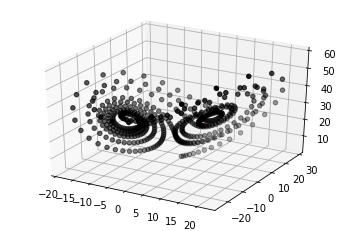

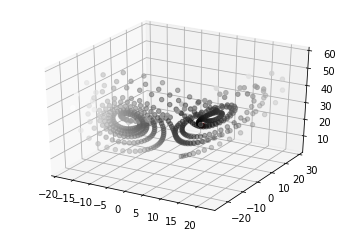

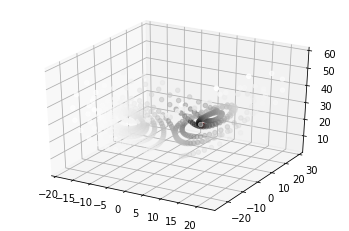

In [44]:
thetas = [0,.1,2]
for theta in thetas: 
    # now we can actually set the weight using our weight func
    for idx, row in lorenz.iterrows():
        dist = lorenz.iloc[idx-1,3]
        weighted_dist = np.exp( -theta*dist/dist_scale )
        lorenz.iloc[idx-1,4] = weighted_dist
    # plot our weighted data - dark points have higher weight
    ax = plt.figure().add_subplot(111,projection="3d")
    ax.scatter(lorenz.iloc[:,0],lorenz.iloc[:,1],lorenz.iloc[:,2],
                c=1-lorenz.iloc[:,4],cmap="gray")
    ax.scatter( query_pt[0],query_pt[1],query_pt[2], color="red")
    plt.show()
# each of the plots below correspond to a theta value which defines
# the exponential weighting scale for the data

Nice. Our library is weighted such that points in the same state (lobe) have higher weight than those in other states.

Now that we have our library weighted, we can construct the linear model.

The linear model is just an [autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model), but when evaluating the least-squares solution, we apply our computed weights to the library. Note that normally in EDM we use embeddings to reconstruct the state space via lags of an observer, which is more consistent with the idea of an autoregressive model, but in this case we're just using the entire Lorenz system as our input data.
A quick recap on an autoregressive (AR) model: it's a linear function for predicting the next point in a time series  given the past $p$ previous values (lags). Basically, we are trying to construct a linear transformation from point $x$ to point $x+1$ with the $p$ values preceding $x$, by showing the model |libary| instances of going from $x,x-1,..,x-p$ to $x+1$.
Also note that the response vector is the next point for every library point, since we are trying to compute a function that outputs the next point given the current point and its $p$ prior values.

In [45]:
response_vec = lorenz[['x']][1:]
model        = lorenz[['x','y','z']][:-1]
# insert column of 1's to compute the error/const of the AR model (sub 1 since last pt has no next pt)
model.insert(0,"err_const",np.ones(lorenz.shape[0]-1))
print(model,response_vec)

     err_const         x         y          z
0          1.0  2.000000  3.000000   4.000000
1          1.0  2.200000  3.900000   3.906667
2          1.0  2.540000  4.882107   3.869911
3          1.0  3.008421  6.010273   3.911527
4          1.0  3.608792  7.339433   4.064541
..         ...       ...       ...        ...
494        1.0  6.292096  5.223800  26.124052
495        1.0  6.078436  5.355396  25.388142
496        1.0  5.933828  5.565809  24.685157
497        1.0  5.860225  5.847887  24.029146
498        1.0  5.857757  6.196331  23.432990

[499 rows x 4 columns]             x
1    2.200000
2    2.540000
3    3.008421
4    3.608792
5    4.354920
..        ...
495  6.078436
496  5.933828
497  5.860225
498  5.857757
499  5.925472

[499 rows x 1 columns]


In [46]:
# weight our library and response vec
weight_matrix = np.identity(lorenz.shape[0]-1) * lorenz[['weight']][:-1].to_numpy()
model         = np.dot(weight_matrix,model.to_numpy())
response_vec  = np.dot(weight_matrix,response_vec.to_numpy())

In [47]:
# solve for our weights (least squares since non-unique solution)
import numpy.linalg as linalg
solution = linalg.lstsq( model, response_vec, rcond=None )[0]
model_const, model_func = solution[0], solution[1:]

In [48]:
# apply our computed model function to our query point to get our next point
pred_pt = model_const + np.dot(query_pt, model_func)
error   = pred_pt - truth_pt
print("true point {0}, our pred {1}, error {2}".format(pred_pt[0], truth_pt[0], error[0]))

true point 6.265217598912343, our pred 6.26521759891235, error -7.105427357601002e-15


Our prediction was accurate; nice.
Note that `SMAP()` repeats this process on every query point, since every query point is potentially in a different state in phase space, hence the *sequentially locally* in sequentially locally weighted global linear maps.